<a href="https://colab.research.google.com/github/chowdhurymoontaha/soft_ComputerLab/blob/main/170104099_exp_01_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  from google.colab import drive

drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os
from os import path
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
!unzip -uq "/content/gdrive/MyDrive/Colab Notebooks/softCompAssignment2/Dataset C.zip" -d "/content/gdrive/MyDrive/Colab Notebooks/softCompAssignment2/DatasetC"

In [ ]:
df_c_csv=pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/softCompAssignment2/DatasetC/training-c.csv")
df_c_csv.head()

,filename,original filename,scanid,digit,database name original,contributing team,database name
0,c00000.png,Scan_280_digit_6_num_7.png,280,6,OngkoDB,Buet_Backpropers,training-c
1,c00001.png,Scan_29_digit_1_num_1.png,29,1,OngkoDB,Buet_Backpropers,training-c
2,c00002.png,Scan_131_digit_3_num_1.png,131,3,OngkoDB,Buet_Backpropers,training-c
3,c00003.png,Scan_160_digit_2_num_2.png,160,2,OngkoDB,Buet_Backpropers,training-c
4,c00004.png,Scan_202_digit_7_num_0.png,202,7,OngkoDB,Buet_Backpropers,training-c


In [ ]:
df_c_csv =df_c_csv.drop(columns=['original filename', 'scanid',
       'database name original', 'contributing team', 'database name'])
df_c_csv.head()

,filename,digit
0,c00000.png,6
1,c00001.png,1
2,c00002.png,3
3,c00003.png,2
4,c00004.png,7


In [ ]:
df_c_csv.shape

(24298, 2)

In [ ]:
PATH = "/content/gdrive/MyDrive/Colab Notebooks/softCompAssignment2/DatasetC"
os.listdir(PATH)

['training-c', 'training-c.csv']

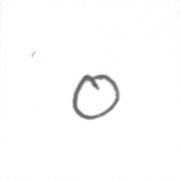

In [ ]:
from PIL import Image
data_dir = '/content/gdrive/MyDrive/Colab Notebooks/softCompAssignment2/DatasetC/training-c'
name = os.listdir(data_dir)[10]
Image.open(data_dir+"/"+name)

In [ ]:
TRAIN_PATH =  '/content/gdrive/MyDrive/Colab Notebooks/softCompAssignment2/DatasetC/train'

In [ ]:
#making folder train
os.mkdir(TRAIN_PATH)

In [ ]:
#import shutil
#import os

os.chdir('/content/gdrive/MyDrive/Colab Notebooks/softCompAssignment2/DatasetC/training-c')
dst_dir = '/content/gdrive/MyDrive/Colab Notebooks/softCompAssignment2/DatasetC/train'
for f in os.listdir():
    shutil.copy(f, dst_dir)

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
# Normalizing data
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(180),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(180),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(df_c_csv, TRAIN_PATH, train_transform)
test_data = Dataset(df_c_csv,TRAIN_PATH, test_transform)

print("Trainig Samples: ",len(train_data))

Trainig Samples:  24298


#Experiment-1
#Combination-1:
iteration=20000, epoch=16, lr=0.01, batch size=20, optimizer=Adam, num_hidden = 200, Layer=6, activations=ReLU, Loss function=CrossEntropyLoss

In [ ]:
# Hyperparameters

batch_size = 20
num_iters = 20000
num_hidden = 200
input_dim = 180*180 # num_features 
output_dim = 10
save_model = True

learning_rate = 0.01


# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

16


In [ ]:
#batch size
#batch_size = 20

# split data 20% for testing
test_size = 0.2

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:972
Test dataloader:243


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 32400 --> 200
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 200 --> 200
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 200 --> 200
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()

        
        ### 4th hidden layer: 200 --> 200
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 4th hidden layer
        self.relu_4 = nn.ReLU()

        ### 5th hidden layer: 200 --> 200
        self.linear_5 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 5th hidden layer
        self.relu_5 = nn.ReLU()

        ### 6th hidden layer: 200 --> 200
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 6th hidden layer
        self.relu_6 = nn.ReLU()


        ### Output layer: 200 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 4th hidden layer
        out = self.relu_4(out)

        ### 5thd hidden layer
        out  = self.linear_5(out)
        ### Non-linearity in 5th hidden layer
        out = self.relu_5(out)

        ### 6th hidden layer
        out  = self.linear_6(out)
        ### Non-linearity in 6th hidden layer
        out = self.relu_6(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [ ]:
# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=32400, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    print(epoch)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 180*180).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))


0
1
Iteration: 1000. Loss: 2.3164916038513184. Accuracy: 10.351924264251904
2
Iteration: 2000. Loss: 2.3116366863250732. Accuracy: 9.220004116073266
3
Iteration: 3000. Loss: 2.284975528717041. Accuracy: 9.878575838649928
4
Iteration: 4000. Loss: 2.295339345932007. Accuracy: 9.508129244700555
5
Iteration: 5000. Loss: 2.304908275604248. Accuracy: 9.878575838649928
6
Iteration: 6000. Loss: 2.303511142730713. Accuracy: 10.166700967277217
7
Iteration: 7000. Loss: 2.310652494430542. Accuracy: 10.804692323523359
8
Iteration: 8000. Loss: 2.3198015689849854. Accuracy: 9.878575838649928
9
Iteration: 9000. Loss: 2.301771879196167. Accuracy: 9.816834739658367
10
Iteration: 10000. Loss: 2.302553415298462. Accuracy: 10.351924264251904
11
Iteration: 11000. Loss: 2.3003268241882324. Accuracy: 9.220004116073266
12
Iteration: 12000. Loss: 2.3001599311828613. Accuracy: 10.351924264251904
13
Iteration: 13000. Loss: 2.3036296367645264. Accuracy: 9.220004116073266
14
Iteration: 14000. Loss: 2.31177806854248

In [26]:
comb1={'Loss':[2.3164916038513184,2.3116366863250732,2.284975528717041,2.295339345932007,2.304908275604248,2.303511142730713,
               2.310652494430542,2.3198015689849854,2.301771879196167,2.302553415298462,2.3003268241882324,2.3001599311828613,
               2.3036296367645264,2.3117780685424805,2.30698823928833], 
       'Accuracy':[10.351924264251904,9.220004116073266,9.878575838649928,9.508129244700555,9.878575838649928,10.166700967277217,
                   10.804692323523359,9.878575838649928,9.816834739658367,10.351924264251904,9.220004116073266,10.351924264251904,
                   9.220004116073266,9.220004116073266,9.508129244700555],
       'Iteration':[1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000]}

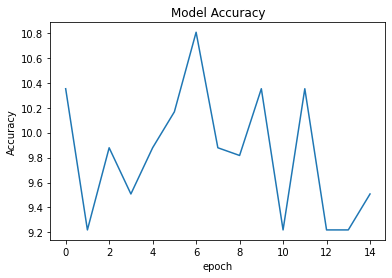

In [24]:
import matplotlib.pyplot as plt

plt.plot(comb1['Accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

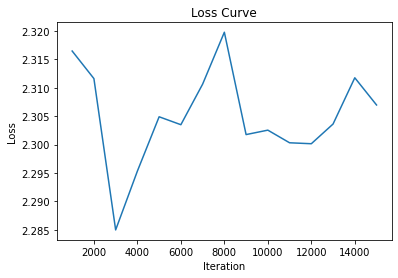

In [31]:
plt.plot(comb1['Iteration'],comb1['Loss'])
plt.title('Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

# Expeiment-2

# Combination-2:
iteration=20000, epoch=82, lr=0.01, batch size=100, optimizer=Adam, num_hidden = 200, Layer=6, activations=ReLU, Loss function=CrossEntropyLoss

In [ ]:
# Hyperparameters

batch_size = 100
num_iters = 20000
num_hidden = 200
input_dim = 180*180 # num_features 
output_dim = 10
save_model = True

learning_rate = 0.01


# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

82


In [ ]:
#batch size
#batch_size = 100

# split data 20% for testing
test_size = 0.2

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:195
Test dataloader:49


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 32400 --> 200
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 200 --> 200
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 200 --> 200
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()

        
        ### 4th hidden layer: 200 --> 200
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 4th hidden layer
        self.relu_4 = nn.ReLU()

        ### 5th hidden layer: 200 --> 200
        self.linear_5 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 5th hidden layer
        self.relu_5 = nn.ReLU()

        ### 6th hidden layer: 200 --> 200
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 6th hidden layer
        self.relu_6 = nn.ReLU()


        ### Output layer: 200 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 4th hidden layer
        out = self.relu_4(out)

        ### 5thd hidden layer
        out  = self.linear_5(out)
        ### Non-linearity in 5th hidden layer
        out = self.relu_5(out)

        ### 6th hidden layer
        out  = self.linear_6(out)
        ### Non-linearity in 6th hidden layer
        out = self.relu_6(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [ ]:
# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=32400, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    print(epoch)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 180*180).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))


0
1
2
3
4
5
Iteration: 1000. Loss: 2.30471134185791. Accuracy: 9.199423749742746
6
7
8
9
10
Iteration: 2000. Loss: 2.297900915145874. Accuracy: 9.220004116073266
11
12
13
14
15
Iteration: 3000. Loss: 2.3025684356689453. Accuracy: 9.220004116073266
16
17
18
19
20
Iteration: 4000. Loss: 2.2998054027557373. Accuracy: 10.290183165260341
21
22
23
24
25
Iteration: 5000. Loss: 2.293428659439087. Accuracy: 9.199423749742746
26
27
28
29
30
Iteration: 6000. Loss: 2.304588556289673. Accuracy: 10.372504630582425
31
32
33
34
35
Iteration: 7000. Loss: 2.30043363571167. Accuracy: 10.55772792755711
36
37
38
39
40
41
Iteration: 8000. Loss: 2.3046042919158936. Accuracy: 9.919736571310969
42
43
44
45
46
Iteration: 9000. Loss: 2.3010454177856445. Accuracy: 10.187281333607737
47
48
49
50
51
Iteration: 10000. Loss: 2.3039557933807373. Accuracy: 9.199423749742746
52
53
54
55
56
Iteration: 11000. Loss: 2.3034822940826416. Accuracy: 9.199423749742746
57
58
59
60
61
Iteration: 12000. Loss: 2.307642698287964. Ac

# Combination-3: 
iteration=20000, epoch=16, lr=0.01, batch size=20, optimizer=Adam, num_hidden = 200, Layer=6, activations=SELU(), Loss function=CrossEntropyLoss

In [ ]:
# Hyperparameters

batch_size = 20
num_iters = 20000
num_hidden = 200
input_dim = 180*180 # num_features 
output_dim = 10
save_model = True

learning_rate = 0.01


# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

16


In [ ]:
#batch size
#batch_size = 100

# split data 20% for testing
test_size = 0.2

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:972
Test dataloader:243


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 32400 --> 200
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.SELU()

        ### 2nd hidden layer: 200 --> 200
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.SELU()

        ### 3rd hidden layer: 200 --> 200
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.SELU()

        
        ### 4th hidden layer: 200 --> 200
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 4th hidden layer
        self.relu_4 = nn.SELU()

        ### 5th hidden layer: 200 --> 200
        self.linear_5 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 5th hidden layer
        self.relu_5 = nn.SELU()

        ### 6th hidden layer: 200 --> 200
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 6th hidden layer
        self.relu_6 = nn.SELU()


        ### Output layer: 200 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 4th hidden layer
        out = self.relu_4(out)

        ### 5thd hidden layer
        out  = self.linear_5(out)
        ### Non-linearity in 5th hidden layer
        out = self.relu_5(out)

        ### 6th hidden layer
        out  = self.linear_6(out)
        ### Non-linearity in 6th hidden layer
        out = self.relu_6(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [ ]:
# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=32400, out_features=200, bias=True)
  (relu_1): SELU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): SELU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): SELU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): SELU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): SELU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (relu_6): SELU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    print(epoch)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 180*180).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))


0
1
Iteration: 1000. Loss: 2.588547945022583. Accuracy: 9.837415105988887
2
Iteration: 2000. Loss: 2.437319278717041. Accuracy: 9.775674006997324
3
Iteration: 3000. Loss: 2.8886985778808594. Accuracy: 9.384647046717431
4
Iteration: 4000. Loss: 3.240769624710083. Accuracy: 9.775674006997324
5
Iteration: 5000. Loss: 2.4193406105041504. Accuracy: 10.104959868285656
6
Iteration: 6000. Loss: 2.346825122833252. Accuracy: 9.384647046717431
7
Iteration: 7000. Loss: 2.6116583347320557. Accuracy: 9.384647046717431
8
Iteration: 8000. Loss: 2.4415242671966553. Accuracy: 10.104959868285656
9
Iteration: 9000. Loss: 2.244157075881958. Accuracy: 10.084379501955135
10
Iteration: 10000. Loss: 2.620990753173828. Accuracy: 10.104959868285656
11
Iteration: 11000. Loss: 2.4733071327209473. Accuracy: 10.104959868285656
12
Iteration: 12000. Loss: 2.518975019454956. Accuracy: 9.384647046717431
13
Iteration: 13000. Loss: 2.409658908843994. Accuracy: 10.084379501955135
14
Iteration: 14000. Loss: 2.44063711166381

#Combination-4
iteration=20000, epoch=82, lr=0.001, batch size=100, optimizer=Adam, num_hidden = 200, Layer=4, activations=SELU, Loss function=CrossEntropyLoss

In [ ]:
# Hyperparameters

batch_size = 100
num_iters = 20000
num_hidden = 200
input_dim = 180*180 # num_features 
output_dim = 10
save_model = True

learning_rate = 0.001


# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

82


In [ ]:
#batch size
#batch_size = 20

# split data 20% for testing
test_size = 0.2

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:195
Test dataloader:49


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 32400 --> 200
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.SELU()

        ### 2nd hidden layer: 200 --> 200
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.SELU()

        ### 3rd hidden layer: 200 --> 200
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.SELU()
 
        ### 4th hidden layer: 200 --> 200
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 4th hidden layer
        self.relu_4 = nn.SELU()

       
        ### 5th hidden layer: 200 --> 200
        #self.linear_5 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 5th hidden layer
        #self.relu_5 = nn.ReLU()

        ### 6th hidden layer: 200 --> 200
        #self.linear_6 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 6th hidden layer
        #self.relu_6 = nn.ReLU()


        ### 7th hidden layer: 200 --> 200
        #self.linear_7 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 7th hidden layer
        #self.relu_7 = nn.ReLU()

        ### 8th hidden layer: 200 --> 200
        #self.linear_8 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 8th hidden layer
        #self.relu_8 = nn.ReLU()'''


        ### Output layer: 200 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 4th hidden layer
        out = self.relu_4(out)

        ### 5thd hidden layer
        #out  = self.linear_5(out)
        ### Non-linearity in 5th hidden layer
        #out = self.relu_5(out)

        ### 6th hidden layer
        #out  = self.linear_6(out)
        ### Non-linearity in 6th hidden layer
        #out = self.relu_6(out)

        ### 7th hidden layer
        #out  = self.linear_7(out)
        ### Non-linearity in 7th hidden layer
        #out = self.relu_7(out)

        ### 8th hidden layer
        #out  = self.linear_8(out)
        ### Non-linearity in 8th hidden layer
        #out = self.relu_8(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [ ]:
# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=32400, out_features=200, bias=True)
  (relu_1): SELU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): SELU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): SELU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): SELU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    print(epoch)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 180*180).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))


0
1
2
Iteration: 500. Loss: 2.1599316596984863. Accuracy: 17.431570281951018
3
4
5
Iteration: 1000. Loss: 1.9047693014144897. Accuracy: 32.84626466351101
6
7
Iteration: 1500. Loss: 1.540004014968872. Accuracy: 39.102696027989296
8
9
10
Iteration: 2000. Loss: 1.7444919347763062. Accuracy: 38.75282980037045
11
12
Iteration: 2500. Loss: 1.6556702852249146. Accuracy: 46.07944021403581
13
14
15
Iteration: 3000. Loss: 1.3507258892059326. Accuracy: 52.9327022020992
16
17
Iteration: 3500. Loss: 1.2784656286239624. Accuracy: 55.83453385470261
18
19
20
Iteration: 4000. Loss: 1.2902441024780273. Accuracy: 56.45194484461823
21
22
23
Iteration: 4500. Loss: 1.184516191482544. Accuracy: 54.88783700349866
24
25
Iteration: 5000. Loss: 1.032442331314087. Accuracy: 58.798106606297594
26
27
28
Iteration: 5500. Loss: 1.044560432434082. Accuracy: 59.436097962543734
29
30
Iteration: 6000. Loss: 0.9440972805023193. Accuracy: 61.20600946696851
31
32
33
Iteration: 6500. Loss: 0.879528820514679. Accuracy: 63.860

#Combination 5
iteration=5000, epoch=16, lr=0.001, batch size=200, optimizer=Adam, num_hidden = 200, Layer=4, activations=SELU, Loss function=CrossEntropyLoss



In [ ]:
# Hyperparameters

batch_size = 200
num_iters = 5000
num_hidden = 200
input_dim = 180*180 # num_features 
output_dim = 10
save_model = True

learning_rate = 0.001


# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

41


In [ ]:
#batch size
#batch_size = 20

# split data 20% for testing
test_size = 0.2

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:98
Test dataloader:25


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 32400 --> 200
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.SELU()

        ### 2nd hidden layer: 200 --> 200
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.SELU()

        ### 3rd hidden layer: 200 --> 200
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.SELU()
 
        ### 4th hidden layer: 200 --> 200
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 4th hidden layer
        self.relu_4 = nn.SELU()

       
        ### 5th hidden layer: 200 --> 200
        #self.linear_5 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 5th hidden layer
        #self.relu_5 = nn.ReLU()

        ### 6th hidden layer: 200 --> 200
        #self.linear_6 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 6th hidden layer
        #self.relu_6 = nn.ReLU()


        ### 7th hidden layer: 200 --> 200
        #self.linear_7 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 7th hidden layer
        #self.relu_7 = nn.ReLU()

        ### 8th hidden layer: 200 --> 200
        #self.linear_8 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 8th hidden layer
        #self.relu_8 = nn.ReLU()'''


        ### Output layer: 200 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 4th hidden layer
        out = self.relu_4(out)

        ### 5thd hidden layer
        #out  = self.linear_5(out)
        ### Non-linearity in 5th hidden layer
        #out = self.relu_5(out)

        ### 6th hidden layer
        #out  = self.linear_6(out)
        ### Non-linearity in 6th hidden layer
        #out = self.relu_6(out)

        ### 7th hidden layer
        #out  = self.linear_7(out)
        ### Non-linearity in 7th hidden layer
        #out = self.relu_7(out)

        ### 8th hidden layer
        #out  = self.linear_8(out)
        ### Non-linearity in 8th hidden layer
        #out = self.relu_8(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [ ]:
# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=32400, out_features=200, bias=True)
  (relu_1): SELU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): SELU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): SELU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): SELU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    print(epoch)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 180*180).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))


0
1
2
3
4
5
Iteration: 500. Loss: 2.0474181175231934. Accuracy: 32.702202099197365
6
7
8
9
10
Iteration: 1000. Loss: 1.5499151945114136. Accuracy: 46.75859230294299
11
12
13
14
15
Iteration: 1500. Loss: 1.2342454195022583. Accuracy: 52.500514509158265
16
17
18
19
20
Iteration: 2000. Loss: 1.2937580347061157. Accuracy: 57.68676682444948
21
22
23
24
25
Iteration: 2500. Loss: 0.9670025110244751. Accuracy: 61.30891129862111
26
27
28
29
30
Iteration: 3000. Loss: 0.9058560729026794. Accuracy: 64.39596624819922
31
32
33
34
35
Iteration: 3500. Loss: 0.7554568648338318. Accuracy: 64.16958221856349
36
37
38
39
40
Iteration: 4000. Loss: 0.8808007836341858. Accuracy: 72.03128215682239


# Combination-6 - My Best Model
iteration=20000, epoch=82, lr=0.001, batch size=200, optimizer=Adam, num_hidden = 200, Layer=4, activations=SELU, Loss function=CrossEntropyLoss



In [ ]:
# Hyperparameters

batch_size = 200
num_iters = 20000
num_hidden = 200
input_dim = 180*180 # num_features 
output_dim = 10
save_model = True

learning_rate = 0.001


# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

164


In [ ]:
#batch size
#batch_size = 20

# split data 20% for testing
test_size = 0.2

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:98
Test dataloader:25


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 32400 --> 200
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.SELU()

        ### 2nd hidden layer: 200 --> 200
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.SELU()

        ### 3rd hidden layer: 200 --> 200
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.SELU()
 
        ### 4th hidden layer: 200 --> 200
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 4th hidden layer
        self.relu_4 = nn.SELU()

       
        ### 5th hidden layer: 200 --> 200
        #self.linear_5 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 5th hidden layer
        #self.relu_5 = nn.ReLU()

        ### 6th hidden layer: 200 --> 200
        #self.linear_6 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 6th hidden layer
        #self.relu_6 = nn.ReLU()


        ### 7th hidden layer: 200 --> 200
        #self.linear_7 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 7th hidden layer
        #self.relu_7 = nn.ReLU()

        ### 8th hidden layer: 200 --> 200
        #self.linear_8 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 8th hidden layer
        #self.relu_8 = nn.ReLU()'''


        ### Output layer: 200 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 4th hidden layer
        out = self.relu_4(out)

        ### 5thd hidden layer
        #out  = self.linear_5(out)
        ### Non-linearity in 5th hidden layer
        #out = self.relu_5(out)

        ### 6th hidden layer
        #out  = self.linear_6(out)
        ### Non-linearity in 6th hidden layer
        #out = self.relu_6(out)

        ### 7th hidden layer
        #out  = self.linear_7(out)
        ### Non-linearity in 7th hidden layer
        #out = self.relu_7(out)

        ### 8th hidden layer
        #out  = self.linear_8(out)
        ### Non-linearity in 8th hidden layer
        #out = self.relu_8(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [ ]:
# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=32400, out_features=200, bias=True)
  (relu_1): SELU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): SELU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): SELU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): SELU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    print(epoch)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 180*180).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))


0
1
2
3
4
5
Iteration: 500. Loss: 2.0695416927337646. Accuracy: 27.14550318995678
6
7
8
9
10
Iteration: 1000. Loss: 1.6994267702102661. Accuracy: 40.64622350277835
11
12
13
14
15
Iteration: 1500. Loss: 1.4769307374954224. Accuracy: 42.39555464087261
16
17
18
19
20
Iteration: 2000. Loss: 1.6211177110671997. Accuracy: 54.04404198394732
21
22
23
24
25
Iteration: 2500. Loss: 1.0237088203430176. Accuracy: 61.617616793578925
26
27
28
29
30
Iteration: 3000. Loss: 0.9095052480697632. Accuracy: 66.59806544556493
31
32
33
34
35
Iteration: 3500. Loss: 0.7204372882843018. Accuracy: 71.90779995883926
36
37
38
39
40
Iteration: 4000. Loss: 0.7206649780273438. Accuracy: 66.45400288125128
41
42
43
44
45
Iteration: 4500. Loss: 0.5279945731163025. Accuracy: 74.56266721547644
46
47
48
49
50
51
Iteration: 5000. Loss: 0.6024489402770996. Accuracy: 68.14159292035399
52
53
54
55
56
Iteration: 5500. Loss: 0.45019420981407166. Accuracy: 72.21650545379708
57
58
59
60
61
Iteration: 6000. Loss: 0.36627519130706787

In [32]:
comb6={'Loss6':[1.6994267702102661,1.6211177110671997,0.9095052480697632,0.7206649780273438,0.6024489402770996,0.36627519130706787,0.3987882137298584,
                0.24038708209991455,0.1797271966934204,0.13791294395923615,0.3962131440639496,0.1470571756362915,0.0674719586968422,0.2883085012435913,
                0.24027709662914276,0.12690798938274384],
       'Iteration6':[1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000,16000]
       }

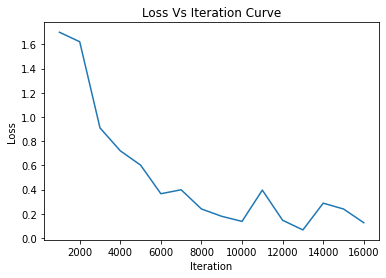

In [34]:
plt.plot(comb6['Iteration6'],comb6['Loss6'])
plt.title('Loss Vs Iteration Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

# Combination-7
iteration=15000, epoch=82, lr=0.001, batch size=200, optimizer=Adam, num_hidden = 200, Layer=4, activations=SELU, Loss function=CrossEntropyLoss



In [ ]:
# Hyperparameters

batch_size = 200
num_iters = 15000
num_hidden = 200
input_dim = 180*180 # num_features 
output_dim = 10
save_model = True

learning_rate = 0.001


# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

123


In [ ]:
#batch size
#batch_size = 20

# split data 20% for testing
test_size = 0.2

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:98
Test dataloader:25


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 32400 --> 200
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.SELU()

        ### 2nd hidden layer: 200 --> 200
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.SELU()

        ### 3rd hidden layer: 200 --> 200
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.SELU()
 
        ### 4th hidden layer: 200 --> 200
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 4th hidden layer
        self.relu_4 = nn.SELU()

       
        ### 5th hidden layer: 200 --> 200
        #self.linear_5 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 5th hidden layer
        #self.relu_5 = nn.ReLU()

        ### 6th hidden layer: 200 --> 200
        #self.linear_6 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 6th hidden layer
        #self.relu_6 = nn.ReLU()


        ### 7th hidden layer: 200 --> 200
        #self.linear_7 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 7th hidden layer
        #self.relu_7 = nn.ReLU()

        ### 8th hidden layer: 200 --> 200
        #self.linear_8 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 8th hidden layer
        #self.relu_8 = nn.ReLU()'''


        ### Output layer: 200 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 4th hidden layer
        out = self.relu_4(out)

        ### 5thd hidden layer
        #out  = self.linear_5(out)
        ### Non-linearity in 5th hidden layer
        #out = self.relu_5(out)

        ### 6th hidden layer
        #out  = self.linear_6(out)
        ### Non-linearity in 6th hidden layer
        #out = self.relu_6(out)

        ### 7th hidden layer
        #out  = self.linear_7(out)
        ### Non-linearity in 7th hidden layer
        #out = self.relu_7(out)

        ### 8th hidden layer
        #out  = self.linear_8(out)
        ### Non-linearity in 8th hidden layer
        #out = self.relu_8(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [ ]:
# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=32400, out_features=200, bias=True)
  (relu_1): SELU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): SELU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): SELU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): SELU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    print(epoch)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 180*180).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))


0
1
2
3
4
5
Iteration: 500. Loss: 1.8637001514434814. Accuracy: 31.30273718872196
6
7
8
9
10
Iteration: 1000. Loss: 1.8975725173950195. Accuracy: 37.682650751183374
11
12
13
14
15
Iteration: 1500. Loss: 1.5018588304519653. Accuracy: 46.840913768265075
16
17
18
19
20
Iteration: 2000. Loss: 1.3317298889160156. Accuracy: 53.159086231734925
21
22
23
24
25
Iteration: 2500. Loss: 0.9394384026527405. Accuracy: 59.88886602181519
26
27
28
29
30
Iteration: 3000. Loss: 0.8362199664115906. Accuracy: 65.93949372298827
31
32
33
34
35
Iteration: 3500. Loss: 0.6445252299308777. Accuracy: 67.5653426630994
36
37
38
39
40
Iteration: 4000. Loss: 0.877051591873169. Accuracy: 62.07038485285038
41
42
43
44
45
Iteration: 4500. Loss: 0.893920361995697. Accuracy: 65.46614529738629
46
47
48
49
50
51
Iteration: 5000. Loss: 0.5110571384429932. Accuracy: 73.30726486931468
52
53
54
55
56
Iteration: 5500. Loss: 0.41845202445983887. Accuracy: 71.70199629553406
57
58
59
60
61
Iteration: 6000. Loss: 0.6463388204574585. 

#Combination-8
iteration=10000, epoch=82, lr=0.001, batch size=200, optimizer=Adam, num_hidden = 200, Layer=4, activations=SELU, Loss function=CrossEntropyLoss



In [ ]:
# Hyperparameters

batch_size = 200
num_iters = 10000
num_hidden = 200
input_dim = 180*180 # num_features 
output_dim = 10
save_model = True

learning_rate = 0.001


# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

82


In [ ]:
#batch size
#batch_size = 20

# split data 20% for testing
test_size = 0.2

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:98
Test dataloader:25


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 32400 --> 200
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.SELU()

        ### 2nd hidden layer: 200 --> 200
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.SELU()

        ### 3rd hidden layer: 200 --> 200
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.SELU()
 
        ### 4th hidden layer: 200 --> 200
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 4th hidden layer
        self.relu_4 = nn.SELU()

       
        ### 5th hidden layer: 200 --> 200
        #self.linear_5 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 5th hidden layer
        #self.relu_5 = nn.ReLU()

        ### 6th hidden layer: 200 --> 200
        #self.linear_6 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 6th hidden layer
        #self.relu_6 = nn.ReLU()


        ### 7th hidden layer: 200 --> 200
        #self.linear_7 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 7th hidden layer
        #self.relu_7 = nn.ReLU()

        ### 8th hidden layer: 200 --> 200
        #self.linear_8 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 8th hidden layer
        #self.relu_8 = nn.ReLU()'''


        ### Output layer: 200 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 4th hidden layer
        out = self.relu_4(out)

        ### 5thd hidden layer
        #out  = self.linear_5(out)
        ### Non-linearity in 5th hidden layer
        #out = self.relu_5(out)

        ### 6th hidden layer
        #out  = self.linear_6(out)
        ### Non-linearity in 6th hidden layer
        #out = self.relu_6(out)

        ### 7th hidden layer
        #out  = self.linear_7(out)
        ### Non-linearity in 7th hidden layer
        #out = self.relu_7(out)

        ### 8th hidden layer
        #out  = self.linear_8(out)
        ### Non-linearity in 8th hidden layer
        #out = self.relu_8(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [ ]:
# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=32400, out_features=200, bias=True)
  (relu_1): SELU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): SELU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): SELU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): SELU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    print(epoch)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 180*180).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))


0
1
2
3
4
5
Iteration: 500. Loss: 1.9150986671447754. Accuracy: 23.4821979831241
6
7
8
9
10
Iteration: 1000. Loss: 1.6970553398132324. Accuracy: 42.95122453179667
11
12
13
14
15
Iteration: 1500. Loss: 1.4622122049331665. Accuracy: 50.463058242436716
16
17
18
19
20
Iteration: 2000. Loss: 1.176350474357605. Accuracy: 54.99073883515126
21
22
23
24
25
Iteration: 2500. Loss: 0.9785363674163818. Accuracy: 59.97118748713727
26
27
28
29
30
Iteration: 3000. Loss: 0.8151207566261292. Accuracy: 65.30150236674213
31
32
33
34
35
Iteration: 3500. Loss: 0.7794908285140991. Accuracy: 69.66454002881251
36
37
38
39
40
Iteration: 4000. Loss: 0.680691123008728. Accuracy: 71.14632640461001
41
42
43
44
45
Iteration: 4500. Loss: 0.5687867403030396. Accuracy: 73.92467585923029
46
47
48
49
50
51
Iteration: 5000. Loss: 0.4916155934333801. Accuracy: 68.77958427660012
52
53
54
55
56
Iteration: 5500. Loss: 0.42442309856414795. Accuracy: 73.3278452356452
57
58
59
60
61
Iteration: 6000. Loss: 0.4347649812698364. Acc

# Combination-9
iteration=10000, epoch=82, lr=0.001, batch size=200, optimizer=Adam, num_hidden = 250, Layer=4, activations=SELU, Loss function=CrossEntropyLoss

In [ ]:
# Hyperparameters

batch_size = 200
num_iters = 10000
num_hidden = 250
input_dim = 180*180 # num_features 
output_dim = 10
save_model = True

learning_rate = 0.001


# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

82


In [ ]:
#batch size
#batch_size = 20

# split data 20% for testing
test_size = 0.2

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:98
Test dataloader:25


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 32400 --> 200
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.SELU()

        ### 2nd hidden layer: 200 --> 200
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.SELU()

        ### 3rd hidden layer: 200 --> 200
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.SELU()
 
        ### 4th hidden layer: 200 --> 200
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 4th hidden layer
        self.relu_4 = nn.SELU()

       
        ### 5th hidden layer: 200 --> 200
        #self.linear_5 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 5th hidden layer
        #self.relu_5 = nn.ReLU()

        ### 6th hidden layer: 200 --> 200
        #self.linear_6 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 6th hidden layer
        #self.relu_6 = nn.ReLU()


        ### 7th hidden layer: 200 --> 200
        #self.linear_7 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 7th hidden layer
        #self.relu_7 = nn.ReLU()

        ### 8th hidden layer: 200 --> 200
        #self.linear_8 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 8th hidden layer
        #self.relu_8 = nn.ReLU()'''


        ### Output layer: 200 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 4th hidden layer
        out = self.relu_4(out)

        ### 5thd hidden layer
        #out  = self.linear_5(out)
        ### Non-linearity in 5th hidden layer
        #out = self.relu_5(out)

        ### 6th hidden layer
        #out  = self.linear_6(out)
        ### Non-linearity in 6th hidden layer
        #out = self.relu_6(out)

        ### 7th hidden layer
        #out  = self.linear_7(out)
        ### Non-linearity in 7th hidden layer
        #out = self.relu_7(out)

        ### 8th hidden layer
        #out  = self.linear_8(out)
        ### Non-linearity in 8th hidden layer
        #out = self.relu_8(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [ ]:
# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=32400, out_features=250, bias=True)
  (relu_1): SELU()
  (linear_2): Linear(in_features=250, out_features=250, bias=True)
  (relu_2): SELU()
  (linear_3): Linear(in_features=250, out_features=250, bias=True)
  (relu_3): SELU()
  (linear_4): Linear(in_features=250, out_features=250, bias=True)
  (relu_4): SELU()
  (linear_out): Linear(in_features=250, out_features=10, bias=True)
)

In [ ]:
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    print(epoch)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 180*180).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))


0
1
2
3
4
5
Iteration: 500. Loss: 1.9172122478485107. Accuracy: 29.82095081292447
6
7
8
9
10
Iteration: 1000. Loss: 1.7936608791351318. Accuracy: 42.45729573986417
11
12
13
14
15
Iteration: 1500. Loss: 1.5734988451004028. Accuracy: 47.478905124511215
16
17
18
19
20
Iteration: 2000. Loss: 1.0095208883285522. Accuracy: 56.32846264663511
21
22
23
24
25
Iteration: 2500. Loss: 1.1114596128463745. Accuracy: 61.96748302119778
26
27
28
29
30
Iteration: 3000. Loss: 1.011440396308899. Accuracy: 57.64560609178844
31
32
33
34
35
Iteration: 3500. Loss: 0.8413827419281006. Accuracy: 66.90677094052275
36
37
38
39
40
Iteration: 4000. Loss: 0.807898759841919. Accuracy: 70.87878164231323
41
42
43
44
45
Iteration: 4500. Loss: 0.6377882957458496. Accuracy: 72.60753241407697
46
47
48
49
50
51
Iteration: 5000. Loss: 0.7013267278671265. Accuracy: 71.45503189956781
52
53
54
55
56
Iteration: 5500. Loss: 0.47322365641593933. Accuracy: 74.87137271043424
57
58
59
60
61
Iteration: 6000. Loss: 0.5446150898933411. A

#Combination-10
iteration=10000, epoch=82, lr=0.001, batch size=200, optimizer=Adam, num_hidden = 200, Layer=4, activations=GELU, Loss function=CrossEntropyLoss

In [ ]:
# Hyperparameters

batch_size = 200
num_iters = 10000
num_hidden = 200
input_dim = 180*180 # num_features 
output_dim = 10
save_model = True

learning_rate = 0.001


# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

82


In [ ]:
#batch size
#batch_size = 20

# split data 20% for testing
test_size = 0.2

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:98
Test dataloader:25


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 32400 --> 200
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.GELU()

        ### 2nd hidden layer: 200 --> 200
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.GELU()

        ### 3rd hidden layer: 200 --> 200
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.GELU()
 
        ### 4th hidden layer: 200 --> 200
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 4th hidden layer
        self.relu_4 = nn.GELU()

       
        ### 5th hidden layer: 200 --> 200
        #self.linear_5 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 5th hidden layer
        #self.relu_5 = nn.ReLU()

        ### 6th hidden layer: 200 --> 200
        #self.linear_6 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 6th hidden layer
        #self.relu_6 = nn.ReLU()


        ### 7th hidden layer: 200 --> 200
        #self.linear_7 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 7th hidden layer
        #self.relu_7 = nn.ReLU()

        ### 8th hidden layer: 200 --> 200
        #self.linear_8 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 8th hidden layer
        #self.relu_8 = nn.ReLU()'''


        ### Output layer: 200 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 4th hidden layer
        out = self.relu_4(out)

        ### 5thd hidden layer
        #out  = self.linear_5(out)
        ### Non-linearity in 5th hidden layer
        #out = self.relu_5(out)

        ### 6th hidden layer
        #out  = self.linear_6(out)
        ### Non-linearity in 6th hidden layer
        #out = self.relu_6(out)

        ### 7th hidden layer
        #out  = self.linear_7(out)
        ### Non-linearity in 7th hidden layer
        #out = self.relu_7(out)

        ### 8th hidden layer
        #out  = self.linear_8(out)
        ### Non-linearity in 8th hidden layer
        #out = self.relu_8(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [ ]:
# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=32400, out_features=200, bias=True)
  (relu_1): GELU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): GELU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): GELU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): GELU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    print(epoch)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 180*180).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))


0
1
2
3
4
5
Iteration: 500. Loss: 2.1001312732696533. Accuracy: 21.012554023461618
6
7
8
9
10
Iteration: 1000. Loss: 1.971979022026062. Accuracy: 30.067915208890717
11
12
13
14
15
Iteration: 1500. Loss: 1.8863804340362549. Accuracy: 32.57871990121424
16
17
18
19
20
Iteration: 2000. Loss: 1.8646554946899414. Accuracy: 33.340193455443504
21
22
23
24
25
Iteration: 2500. Loss: 1.772462010383606. Accuracy: 35.27474789051245
26
27
28
29
30
Iteration: 3000. Loss: 2.036921262741089. Accuracy: 35.85099814776703
31
32
33
34
35
Iteration: 3500. Loss: 1.7558461427688599. Accuracy: 35.37764972216505
36
37
38
39
40
Iteration: 4000. Loss: 1.85085129737854. Accuracy: 32.99032722782466
41
42
43
44
45
Iteration: 4500. Loss: 1.661268711090088. Accuracy: 37.92961514714962
46
47
48
49
50
51
Iteration: 5000. Loss: 1.9628487825393677. Accuracy: 27.865816011525006
52
53
54
55
56
Iteration: 5500. Loss: 1.750828742980957. Accuracy: 36.53015023667421
57
58
59
60
61
Iteration: 6000. Loss: 1.6680352687835693. Accu

# Performance Testing with another Dataset

# Experiment1-Combination 1

In [22]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Hyperparameters
batch_size = 20
num_iters = 20000
input_dim = 28*28
num_hidden = 200
output_dim = 10

learning_rate = 0.01

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),  # Normalize the image to [0-1] from [0-255]
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())


num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 32400 --> 200
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 200 --> 200
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 200 --> 200
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()

        
        ### 4th hidden layer: 200 --> 200
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 4th hidden layer
        self.relu_4 = nn.ReLU()

        ### 5th hidden layer: 200 --> 200
        self.linear_5 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 5th hidden layer
        self.relu_5 = nn.ReLU()

        ### 6th hidden layer: 200 --> 200
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 6th hidden layer
        self.relu_6 = nn.ReLU()


        ### Output layer: 200 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 4th hidden layer
        out = self.relu_4(out)

        ### 5thd hidden layer
        out  = self.linear_5(out)
        ### Non-linearity in 5th hidden layer
        out = self.relu_5(out)

        ### 6th hidden layer
        out  = self.linear_6(out)
        ### Non-linearity in 6th hidden layer
        out = self.relu_6(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

model = DeepNeuralNetworkModel(input_size = input_dim,
                           num_classes = output_dim,
                           num_hidden = num_hidden)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.0349723100662231. Accuracy: 84.06
Iteration: 1000. Loss: 0.3094385266304016. Accuracy: 89.28
Iteration: 1500. Loss: 0.4750904142856598. Accuracy: 88.62
Iteration: 2000. Loss: 0.3435335159301758. Accuracy: 81.03
Iteration: 2500. Loss: 0.24113428592681885. Accuracy: 90.9
Iteration: 3000. Loss: 0.23745779693126678. Accuracy: 91.07
Iteration: 3500. Loss: 0.6005517244338989. Accuracy: 89.65
Iteration: 4000. Loss: 0.3076748549938202. Accuracy: 91.1
Iteration: 4500. Loss: 0.41867780685424805. Accuracy: 87.56
Iteration: 5000. Loss: 0.7964999675750732. Accuracy: 79.1
Iteration: 5500. Loss: 0.6939133405685425. Accuracy: 76.76
Iteration: 6000. Loss: 0.39346760511398315. Accuracy: 87.76
Iteration: 6500. Loss: 0.25464463233947754. Accuracy: 89.38
Iteration: 7000. Loss: 0.4782261848449707. Accuracy: 87.39
Iteration: 7500. Loss: 0.20010867714881897. Accuracy: 89.66
Iteration: 8000. Loss: 0.47478875517845154. Accuracy: 86.91
Iteration: 8500. Loss: 0.20659597218036652. Accuracy:

#Experiment 2 For best model-Combination 6

In [21]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Hyperparameters
batch_size = 200
num_iters = 20000
input_dim = 28*28 # num_features 
num_hidden = 200
output_dim = 10

learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),  # Normalize the image to [0-1] from [0-255]
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())


num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 32400 --> 200
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.SELU()

        ### 2nd hidden layer: 200 --> 200
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.SELU()

        ### 3rd hidden layer: 200 --> 200
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.SELU()
 
        ### 4th hidden layer: 200 --> 200
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 4th hidden layer
        self.relu_4 = nn.SELU()

       
        ### 5th hidden layer: 200 --> 200
        #self.linear_5 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 5th hidden layer
        #self.relu_5 = nn.ReLU()

        ### 6th hidden layer: 200 --> 200
        #self.linear_6 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 6th hidden layer
        #self.relu_6 = nn.ReLU()


        ### 7th hidden layer: 200 --> 200
        #self.linear_7 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 7th hidden layer
        #self.relu_7 = nn.ReLU()

        ### 8th hidden layer: 200 --> 200
        #self.linear_8 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 8th hidden layer
        #self.relu_8 = nn.ReLU()'''


        ### Output layer: 200 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 4th hidden layer
        out = self.relu_4(out)

        ### 5thd hidden layer
        #out  = self.linear_5(out)
        ### Non-linearity in 5th hidden layer
        #out = self.relu_5(out)

        ### 6th hidden layer
        #out  = self.linear_6(out)
        ### Non-linearity in 6th hidden layer
        #out = self.relu_6(out)

        ### 7th hidden layer
        #out  = self.linear_7(out)
        ### Non-linearity in 7th hidden layer
        #out = self.relu_7(out)

        ### 8th hidden layer
        #out  = self.linear_8(out)
        ### Non-linearity in 8th hidden layer
        #out = self.relu_8(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

model = DeepNeuralNetworkModel(input_size = input_dim,
                           num_classes = output_dim,
                           num_hidden = num_hidden)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Iteration: 500. Loss: 0.11320113390684128. Accuracy: 94.21
Iteration: 1000. Loss: 0.13235239684581757. Accuracy: 95.74
Iteration: 1500. Loss: 0.0425771102309227. Accuracy: 96.53
Iteration: 2000. Loss: 0.06174154579639435. Accuracy: 97.17
Iteration: 2500. Loss: 0.053917866200208664. Accuracy: 97.11
Iteration: 3000. Loss: 0.05843278020620346. Accuracy: 97.41
Iteration: 3500. Loss: 0.008049875497817993. Accuracy: 97.55
Iteration: 4000. Loss: 0.033867932856082916. Accuracy: 97.75
Iteration: 4500. Loss: 0.0323578417301178. Accuracy: 97.53
Iteration: 5000. Loss: 0.02022767812013626. Accuracy: 97.78
Iteration: 5500. Loss: 0.007144459988921881. Accuracy: 97.89
Iteration: 6000. Loss: 0.06417857855558395. Accuracy: 97.78
Iteration: 6500. Loss: 0.046498361974954605. Accuracy: 97.61
Iteration: 7000. Loss: 0.003038631984964013. Accuracy: 97.98
Iteration: 7500. Loss: 0.01417429931461811. Accuracy: 97.96
Iteration: 8000. Loss: 0.020506955683231354. Accuracy: 97.68
Iteration: 8500. Loss: 0.01163454540